# Esame pratico per Progetto Finale Data Science
Questo notebook mostra come costruire un modello di machine learning per prevedere se l'acqua è potabile in base a valori chimici presenti nel dataset.
# Dataset e Obiettivi:
Utilizzeremo il dataset water_potability dataset, che è un dataset per la classificazione binaria.
Il nostro obiettivo è assicurarci che il modello sia completo e comprenda tutti i controlli necessari per una valutazione corretta.
(https://drive.google.com/drive/folders/1IPRtVoY9A0XiHaxMe2k8Nv1gJx9zKBkM?usp=sharing)

# Importazione di tutte le librerie necessarie

In [ ]:
# Standard library imports (none in your list)

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from scipy import stats
from scipy.stats import randint
from scipy.spatial.distance import mahalanobis
from sklearn.feature_selection import f_classif

# Scikit-learn imports (grouped together)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE


#-----------------------------------------------
# # 1. Comprensione e Preparazione dei Dati
#-----------------------------------------------

In [ ]:
# Caricamento del dataset (dataset da google.colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # Caricamento dataset

df_water = pd.read_csv('/content/drive/MyDrive/S2I/Progetto_Finale_Data_Science/water_potability.csv', encoding='windows-1254', sep=',')


# Analisi del dataframe (EDA)


In [ ]:
print("\nValori dataframe:")
print(df_water.shape)


Valori dataframe:
(3276, 10)


In [ ]:
nulli_assoluti = df_water.isnull().sum()
print("\nValori nulli per colonna (assoluti):")
print(nulli_assoluti)


Valori nulli per colonna (assoluti):
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [ ]:
total_rows = len(df_water)
percent_missing = (nulli_assoluti / total_rows) * 100

# Print the results
print("\nPercentuale di valori mancanti per colonna:")
print(percent_missing)


Percentuale di valori mancanti per colonna:
ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64


Notiamo già un moderato numero di valori mancanti.

In [ ]:
print("\nInformazioni delle colonne\n")
df_water.info(memory_usage="deep")


Informazioni delle colonne

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
print("\Valori nelle colonne\n")
df_water.describe()

\Valori nelle colonne



<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
/tmp/ipython-input-1245114950.py:1: SyntaxWarning: invalid escape sequence '\V'
  print("\Valori nelle colonne\n")


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


# Analisi degli outlier

Definizione funzione per il calcolo della distanza di Mahalanobis per il rilevamento degli outlier

In [ ]:
def mahalanobis_outliers(df, threshold=0.95):
    # Calcola la matrice di covarianza e la sua inversa
    cov_matrix = df.cov().values
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calcola la media per ogni feature
    mean = df.mean().values

    # Calcola la distanza di Mahalanobis per ogni osservazione
    mahalanobis_dist = []
    for i in range(len(df)):
        dist = mahalanobis(df.iloc[i].values, mean, inv_cov_matrix)
        mahalanobis_dist.append(dist)

    # Converte in array numpy
    mahalanobis_dist = np.array(mahalanobis_dist)

    # Trova la soglia basata sulla distribuzione chi-quadrato
    chi2_threshold = stats.chi2.ppf(threshold, df.shape[1])

    # Identifica gli outlier
    outliers = mahalanobis_dist > chi2_threshold

    return mahalanobis_dist, outliers, chi2_threshold

In [ ]:
# Applica Mahalanobis al dataset (escludendo la variabile target)
features = df_water.drop('Potability', axis=1)
mahalanobis_dist, outliers, threshold = mahalanobis_outliers(features)

In [ ]:
print(f"Soglia Mahalanobis (chi-quadrato {0.95*100}%): {threshold:.4f}")
print(f"Numero di outlier rilevati: {sum(outliers)}")
print(f"Percentuale di outlier: {sum(outliers)/len(outliers)*100:.2f}%")

Soglia Mahalanobis (chi-quadrato 95.0%): 16.9190
Numero di outlier rilevati: 0
Percentuale di outlier: 0.00%


Non riusciamo a trovare nessun outlier, ma è sempre meglio fare dei controlli ulteriori con boxplot e violinpot

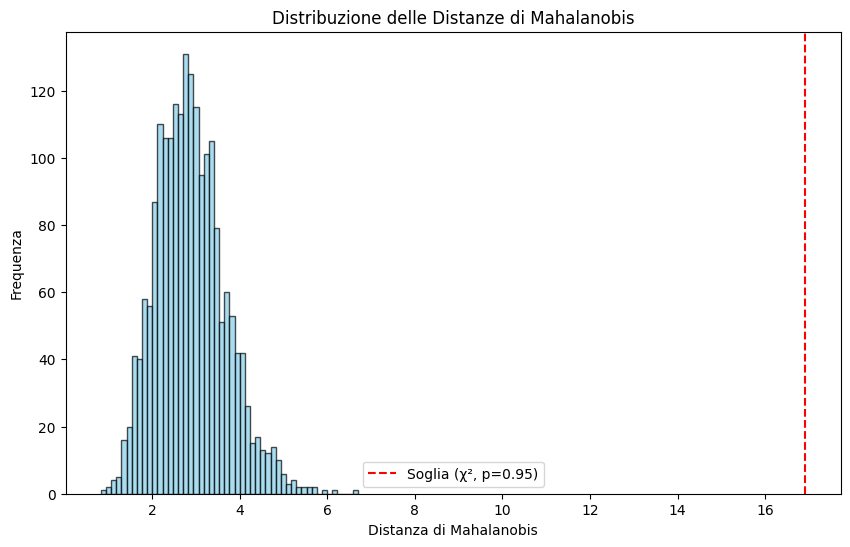

In [ ]:
# Visualizza la distribuzione delle distanze di Mahalanobis
plt.figure(figsize=(10, 6))
plt.hist(mahalanobis_dist, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Soglia (χ², p={0.95})')
plt.xlabel('Distanza di Mahalanobis')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Distanze di Mahalanobis')
plt.legend()
plt.show()

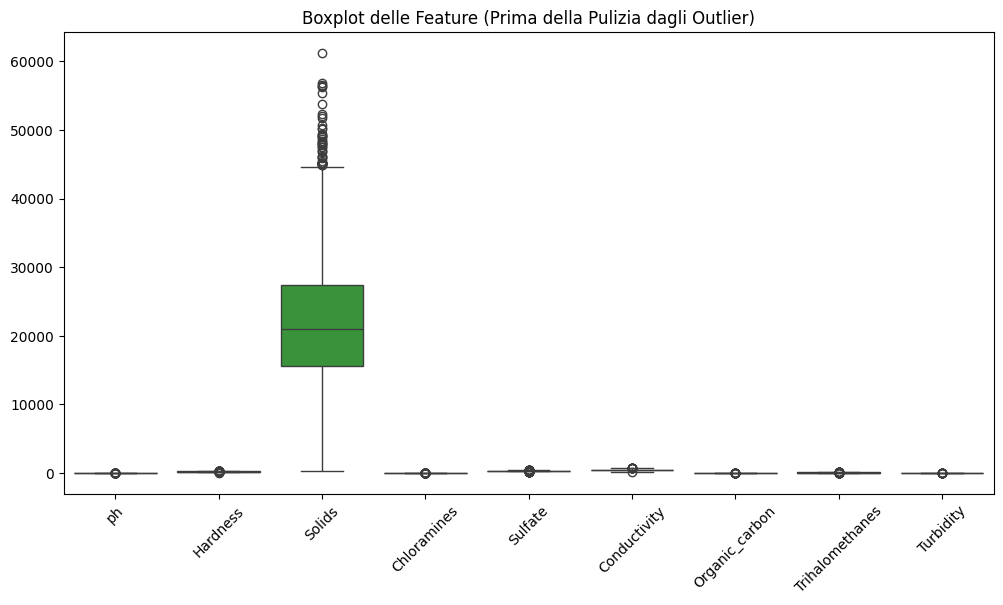

In [ ]:
# Boxplot per feature
plt.figure(figsize=(12,6))
sns.boxplot(data=df_water.drop('Potability', axis=1))
plt.xticks(rotation=45)
plt.title('Boxplot delle Feature (Prima della Pulizia dagli Outlier)')
plt.show()

Non solo notiamo che è presente un outlier ma che molti valori della stessa feature lo sono, dovremmo cercare di aggiustare questo problema prima di lavorare sul nostro modello.

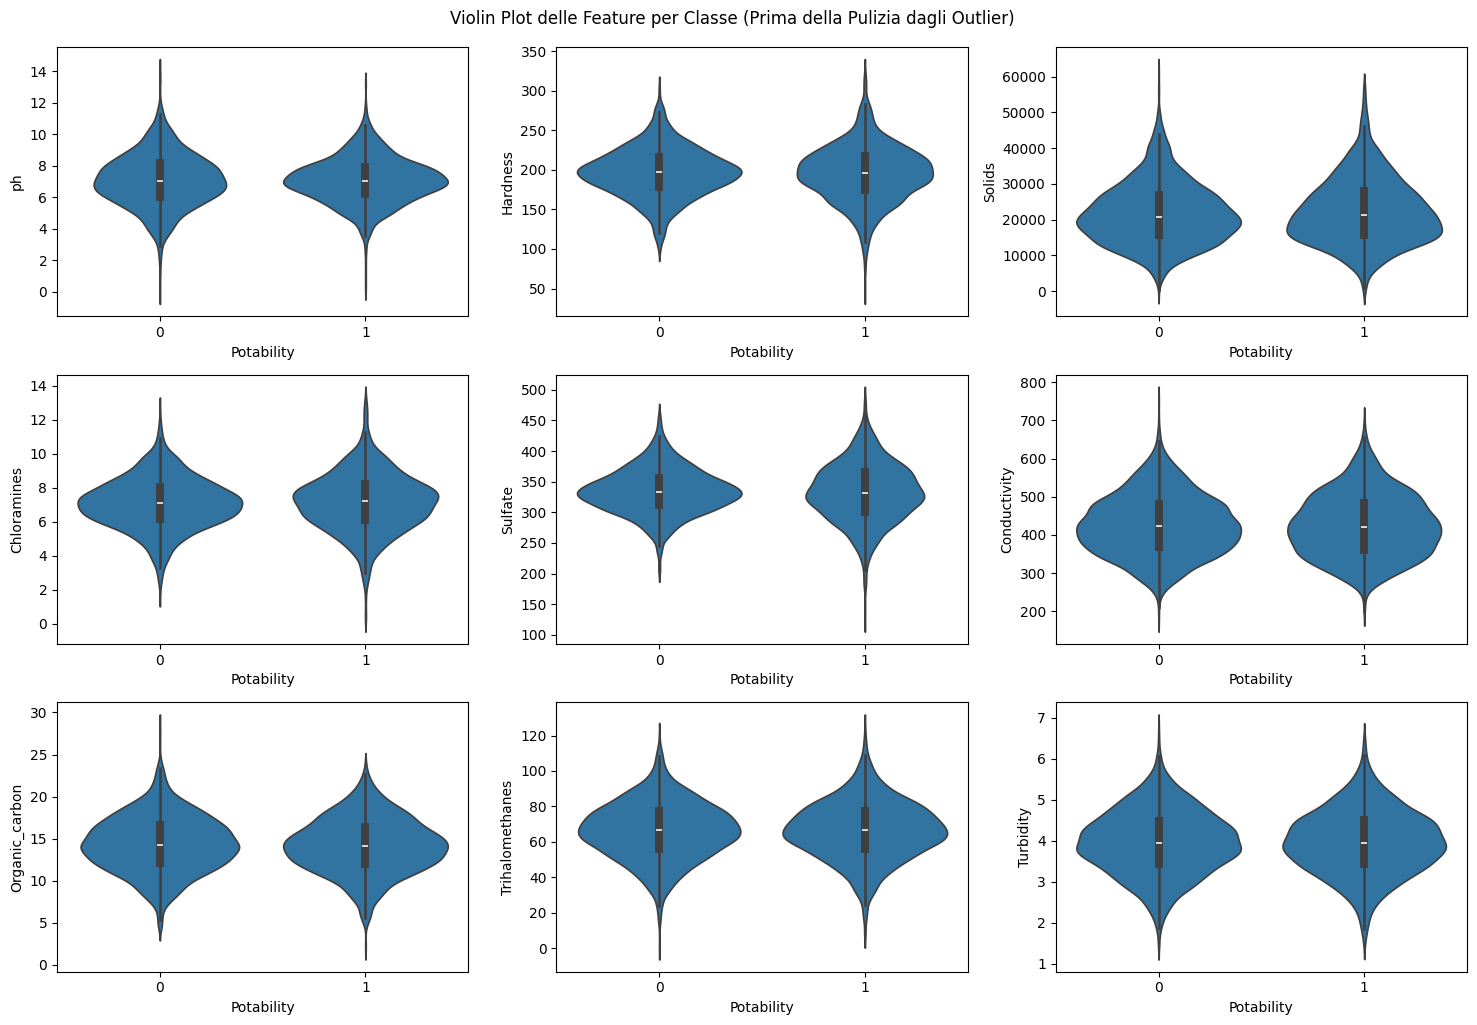

In [ ]:
# Violin plot per classe
fig, axes = plt.subplots(3, 3, figsize=(15,10))
for i, col in enumerate(df_water.columns[:-1]):
    sns.violinplot(x='Potability', y=col, data=df_water, ax=axes[i//3, i%3])
plt.tight_layout()
plt.suptitle('Violin Plot delle Feature per Classe (Prima della Pulizia dagli Outlier)', y=1.02)
plt.show()

  # Divisione dataset in training e test set


In [ ]:
X = df_water.drop('Potability', axis=1)
y = df_water['Potability']

# Dividi il dataset in training e test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nDistribuzione delle classi nel set di addestramento:")
print(pd.Series(y_train).value_counts())

print("\nDistribuzione delle classi nel set di test:")
print(pd.Series(y_test).value_counts())


Distribuzione delle classi nel set di addestramento:
Potability
0    1598
1    1022
Name: count, dtype: int64

Distribuzione delle classi nel set di test:
Potability
0    400
1    256
Name: count, dtype: int64


# Pulizia dati (gestione valori nulli e outlier)
Prima di gestire la colonna con gli outlier, troviamo il metodo migliore per gestire la grande quantità di valori nulli che abbiamo.
Ovviamente eliminarli non è neanche pensabile.

# Definizione dei migliori imputer


In [ ]:
# Modello di riferimento
model = LogisticRegression(max_iter=5000)

# Lista imputer abbastanza completo
imputers = {
    "Media": SimpleImputer(strategy="mean"),
    "Mediana": SimpleImputer(strategy="median"),
    "Moda": SimpleImputer(strategy="most_frequent"),
    "Costante (0)": SimpleImputer(strategy="constant", fill_value=0),
    "KNN (k=2)": KNNImputer(n_neighbors=2),
    "KNN (k=5)": KNNImputer(n_neighbors=5),
    "KNN (k=10)": KNNImputer(n_neighbors=10),
    "KNN (k=25)": KNNImputer(n_neighbors=25),
    "Iterative (default)": IterativeImputer(random_state=0),
    "Iterative (max_iter=10)": IterativeImputer(max_iter=10, random_state=0)
}

In [ ]:
print("\n--- Ricerca del miglior imputer ---")

# Valutazione degli imputer

results = {}

for name, imputer in imputers.items():

    # Addestra un modello (Random Forest in questo caso)
    pipeline = Pipeline(steps=[('imputer', imputer), ('classifier', model)])

    # Valutazione con cross-validation per F1-score
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1_macro', n_jobs=-1)

    # Valutazione con cross-validation per accuracy
    accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

    results[name] = {
        "mean_f1": np.mean(f1_scores),
        "std_f1": np.std(f1_scores),
        "mean_accuracy": np.mean(accuracy_scores),
        "std_accuracy": np.std(accuracy_scores)
    }

    print(f"Imputer: {name}, F1-score medio: {results[name]['mean_f1']:.4f}, Accuracy media: {results[name]['mean_accuracy']:.4f}")



--- Ricerca del miglior imputer ---
Imputer: Media, F1-score medio: 0.3798, Accuracy media: 0.6099
Imputer: Mediana, F1-score medio: 0.3798, Accuracy media: 0.6099
Imputer: Moda, F1-score medio: 0.3789, Accuracy media: 0.6099
Imputer: Costante (0), F1-score medio: 0.3789, Accuracy media: 0.6099
Imputer: KNN (k=2), F1-score medio: 0.3805, Accuracy media: 0.6095
Imputer: KNN (k=5), F1-score medio: 0.3808, Accuracy media: 0.6103
Imputer: KNN (k=10), F1-score medio: 0.3808, Accuracy media: 0.6103
Imputer: KNN (k=25), F1-score medio: 0.3808, Accuracy media: 0.6103
Imputer: Iterative (default), F1-score medio: 0.3798, Accuracy media: 0.6099
Imputer: Iterative (max_iter=10), F1-score medio: 0.3798, Accuracy media: 0.6099


In [ ]:
# Organizza i risultati in un DataFrame per una visualizzazione migliore
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values('mean_accuracy', ascending=False)

In [ ]:
# Stampa i risultati
print("Risultati della valutazione degli imputer (solo CV):")
print(results_df[['mean_f1', 'mean_accuracy']])

Risultati della valutazione degli imputer (solo CV):
                          mean_f1  mean_accuracy
KNN (k=10)               0.380834       0.610305
KNN (k=5)                0.380834       0.610305
KNN (k=25)               0.380834       0.610305
Moda                     0.378852       0.609924
Costante (0)             0.378852       0.609924
Media                    0.379770       0.609923
Mediana                  0.379770       0.609923
Iterative (default)      0.379770       0.609923
Iterative (max_iter=10)  0.379770       0.609923
KNN (k=2)                0.380534       0.609542


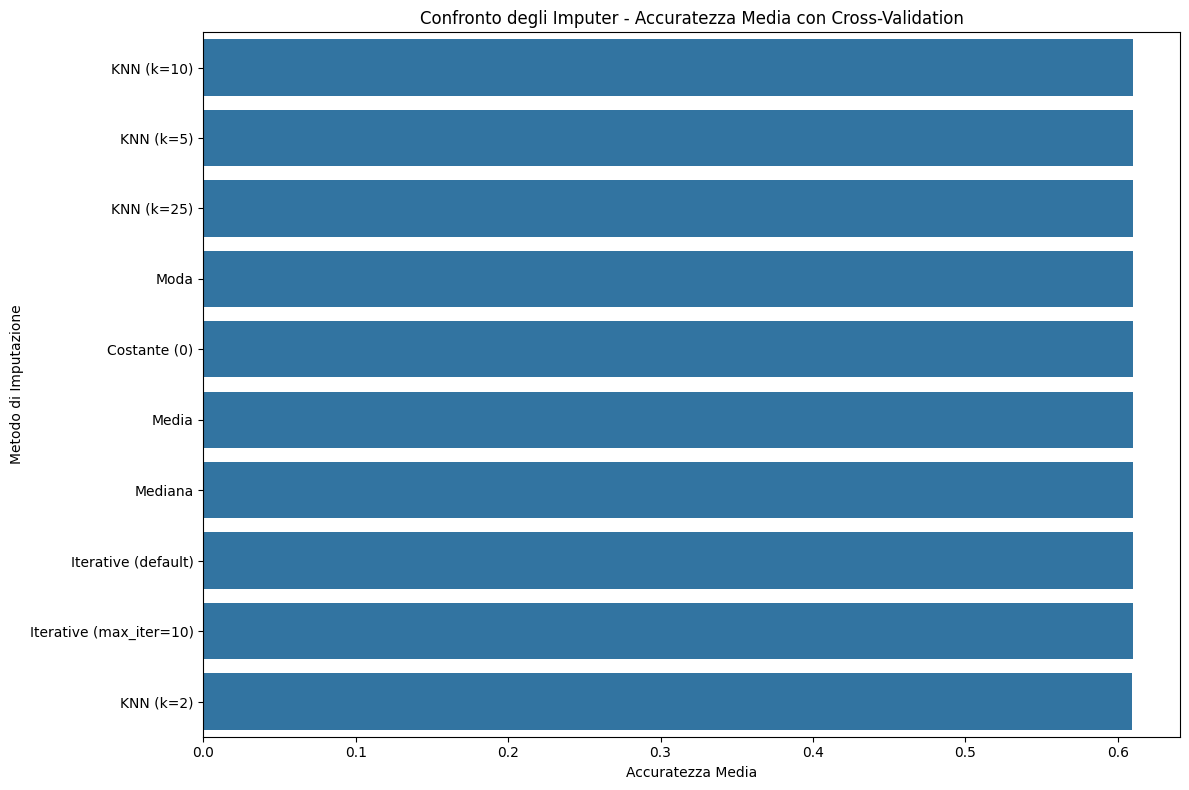

In [ ]:
# Visualizza i risultati
plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['mean_accuracy'], y=results_df.index)
plt.title('Confronto degli Imputer - Accuratezza Media con Cross-Validation')
plt.ylabel('Metodo di Imputazione')
plt.xlabel('Accuratezza Media')
plt.tight_layout()
plt.show()

Con un cv=3 abbiamo trovato KNN=10 come imputer migliore, quindi lo prenderemo e lo useremo per il nostro dataset.

In [ ]:
# Seleziona il miglior imputer in base alla cross-validation
best_imputer_name = results_df.index[0]
best_imputer = imputers[best_imputer_name]

In [ ]:
print(f"\nMiglior imputer: {best_imputer_name}")
print(f"Accuratezza media CV: {results_df.loc[best_imputer_name, 'mean_accuracy']:.4f}")


Miglior imputer: KNN (k=10)
Accuratezza media CV: 0.6103


In [ ]:
# Applica il miglior imputer a tutto il dataset
X_train_imputed = best_imputer.fit_transform(X_train)
X_test_imputed = best_imputer.transform(X_test)

# Colonna con outlier
Ora che abbiamo imputato i valori nulli possiamo gestire meglio l'outlier di 'Solids' tramite una funzione logaritmica cercando di avere una colonna meno sblilanciata.

In [ ]:
X_train['Solids_log'] = np.log1p(X_train['Solids'])

# Trasformazione su X_test
X_test['Solids_log'] = np.log1p(X_test['Solids'])

# Puoi ora rimuovere la colonna originale 'Solids' se non serve più
X_train = X_train.drop('Solids', axis=1)
X_test = X_test.drop('Solids', axis=1)

# Correlazione e relazione feature (matrice di correlazione con heatmap)

Ora che le nostre colonne sono state lavorate possiamo "guardare" dentro di loro e capire se ci sono feature che hanno un peso maggiore nel contesto del target, o se tutte le feature sono importanti per trovare e indovinare correttamente il risultato 'target'.

In [ ]:
# Creazione di DataFrame imputati per l'analisi di correlazione
# Qui uniamo X_train_imputed e y_train per calcolare la correlazione
df_imputed_train = pd.DataFrame(X_train_imputed, columns=X.columns)
df_imputed_train['Target'] = y_train.values

In [ ]:
# Calcolo della matrice di correlazione
correlation_matrix = df_imputed_train.corr()

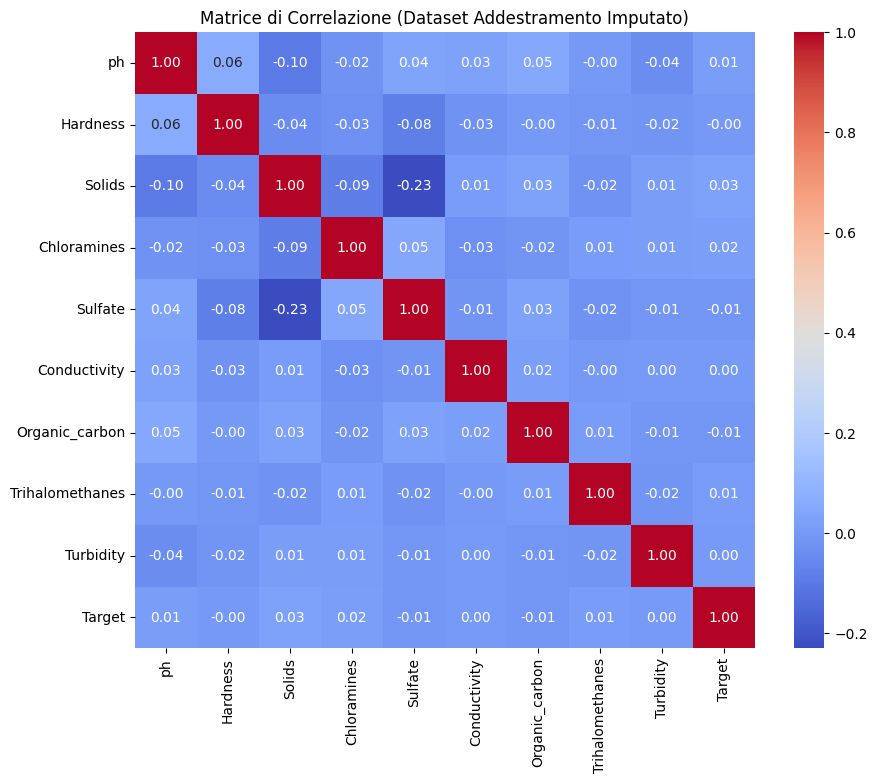

In [ ]:
# Visualizzazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione (Dataset Addestramento Imputato)')
plt.show()

La matrice di correlazione ci mostra che non sono presenti correlazioni lineari forti tra le variabili del dataset.
Questo significa che, almeno per quanto riguarda le relazioni lineari, le variabili non sono particolarmente legate tra loro.
Inoltre, nessuna delle nostre variabili ha una forte correlazione lineare con la variabile Target.
Ovviamente non vuol dire che le feature non siano utili ma che semplicemente le relazioni fra loro sono piu' complesse e dovremmo quindi mantenerle tutte.

In [ ]:
# Analisi delle correlazioni
# Correlazione tra feature e target
print("\nCorrelazione tra Feature e Target:")
print(correlation_matrix['Target'].sort_values(ascending=False))


Correlazione tra Feature e Target:
Target             1.000000
Solids             0.027628
Chloramines        0.017527
ph                 0.012566
Trihalomethanes    0.007884
Conductivity       0.002638
Turbidity          0.001488
Hardness          -0.002302
Sulfate           -0.008960
Organic_carbon    -0.013056
Name: Target, dtype: float64


In [ ]:
# Correlazione tra feature (per la multicollinearità)
print("\nCorrelazione tra Feature:")
feature_corr = correlation_matrix.loc[X.columns, X.columns]
print(feature_corr)


Correlazione tra Feature:
                       ph  Hardness    Solids  Chloramines   Sulfate  \
ph               1.000000  0.060859 -0.096609    -0.024464  0.038174   
Hardness         0.060859  1.000000 -0.042639    -0.029592 -0.080764   
Solids          -0.096609 -0.042639  1.000000    -0.089095 -0.229520   
Chloramines     -0.024464 -0.029592 -0.089095     1.000000  0.045526   
Sulfate          0.038174 -0.080764 -0.229520     0.045526  1.000000   
Conductivity     0.026848 -0.027651  0.006140    -0.030986 -0.013931   
Organic_carbon   0.051092 -0.000819  0.026885    -0.015698  0.028987   
Trihalomethanes -0.000006 -0.012467 -0.020310     0.009870 -0.021557   
Turbidity       -0.040368 -0.017353  0.012851     0.013786 -0.009138   

                 Conductivity  Organic_carbon  Trihalomethanes  Turbidity  
ph                   0.026848        0.051092        -0.000006  -0.040368  
Hardness            -0.027651       -0.000819        -0.012467  -0.017353  
Solids               0.0

#Feature Selection (chi2 e p-value)

In [ ]:
print(pd.DataFrame(X_train_imputed, columns=X_train.columns).dtypes)

# Controlla per valori non numerici
print(pd.DataFrame(X_train_imputed, columns=X_train.columns).head())

ph                 float64
Hardness           float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Solids_log         float64
dtype: object
         ph    Hardness   Chloramines   Sulfate  Conductivity  Organic_carbon  \
0  7.822492  208.636720  22308.821729  5.850328    408.123255      502.789396   
1  6.037428  227.033994  12988.791229  8.476905    392.380529      306.386283   
2  8.445219  228.522860  28966.569327  6.179855    306.229320      361.705354   
3  6.745307  218.424637  21871.838700  7.165509    314.423758      373.050102   
4  6.506488  202.285938  17087.076902  6.201983    326.662368      481.771934   

   Trihalomethanes  Turbidity  Solids_log  
0        16.135732  60.393982    3.835332  
1         7.122391  41.190507    3.594217  
2        14.554220  60.612230    4.400706  
3        16.826619  74.086080    3.902353  
4        16.535186  46.205748    3.5

In [ ]:
# Feature Selection con F-test (ANOVA)

# Calcola i punteggi F per ogni feature
f_scores, p_values = f_classif(X_train_imputed, y_train)

# Crea un DataFrame con i risultati
feature_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'F Score': f_scores,
    'p-value': p_values
}).sort_values('F Score', ascending=False)

print("\nPunteggi F per feature:")
print(feature_scores_df)


Punteggi F per feature:
           Feature   F Score   p-value
2           Solids  1.999819  0.157437
3      Chloramines  0.804501  0.369833
6   Organic_carbon  0.446335  0.504139
0               ph  0.413470  0.520270
4          Sulfate  0.210178  0.646666
7  Trihalomethanes  0.162724  0.686694
5     Conductivity  0.018222  0.892630
1         Hardness  0.013873  0.906247
8        Turbidity  0.005797  0.939317


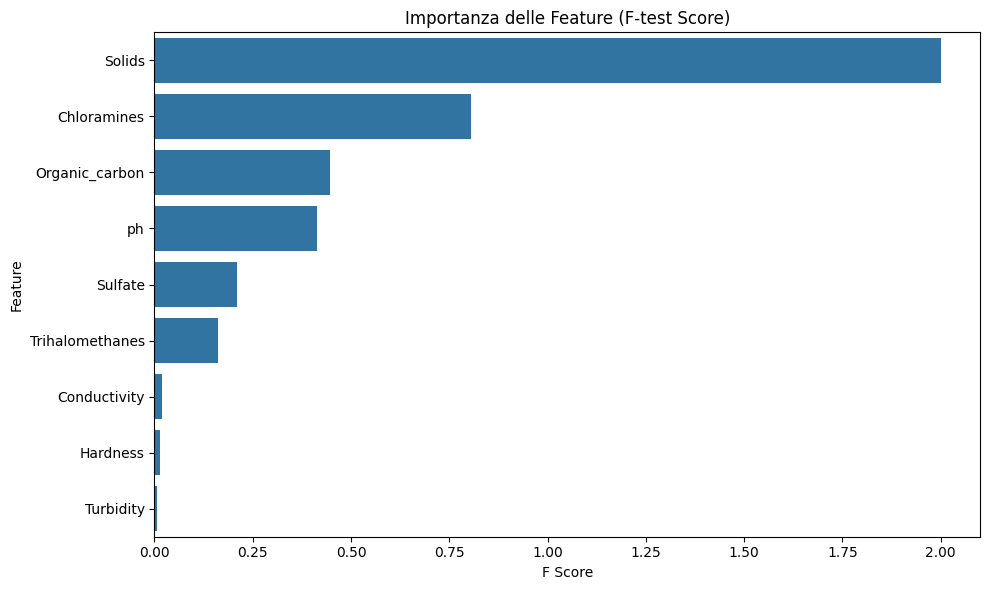

In [ ]:
# Visualizzazione dell'importanza delle feature
plt.figure(figsize=(10, 6))
sns.barplot(x='F Score', y='Feature', data=feature_scores_df)
plt.title('Importanza delle Feature (F-test Score)')
plt.tight_layout()
plt.show()

In [ ]:
# Seleziona le feature migliori basate su p-value < 0.05
significant_features = feature_scores_df[feature_scores_df['p-value'] < 0.05]['Feature'].tolist()
print(f"\nFeature significative (p-value < 0.05): {significant_features}")

# Usa solo le feature significative se ce ne sono
if significant_features:
    df_imputed_train = df_imputed_train[significant_features]
    df_imputed_train = df_imputed_train[significant_features]


Feature significative (p-value < 0.05): []


Dopo aver escluso la possibilità di relazione lineari siamo passati al F-test per valutare se fossero presenti relazione statistiche significative, successivamente usiamo il p-value per verificare che la relazione trovato non sia un caso.
L'F-test ha trovato dei punteggi molto interessanti, i quali però vengono smentiti subito da p-value poiché nessuna feature scende sotto la soglia per essere significativa.

# Bilanciamento delle classi

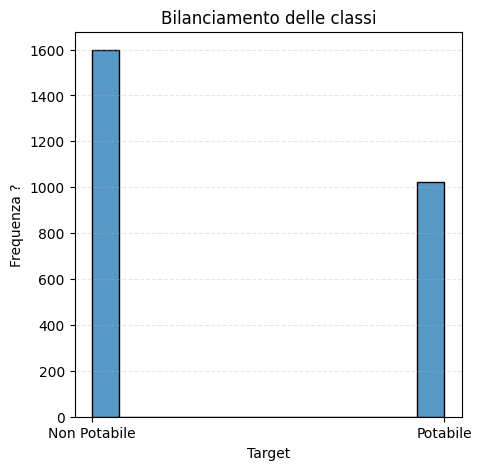

In [ ]:
plt.figure(figsize=(5, 5)) # Imposta le dimensioni del grafico
sns.histplot(data=df_imputed_train, x="Target")
plt.title('Bilanciamento delle classi') # Titolo del grafico
plt.ylabel('Frequenza ?') # Etichetta asse Y
plt.xticks(ticks=[0, 1], labels=['Non Potabile', 'Potabile']) # Etichette personalizzate per l'asse X
plt.grid(axis='y', linestyle='--', alpha=0.3) # Aggiunge una griglia leggera
plt.show()

Inizialmente il nostro dataset è moderatamente skewed verso il "non potabile", proviamo a SMOTE per creare valori fantasma/nuovi fino a raggiungere il 50/50 e quindi un dataset bilanciato.

In [ ]:
# Inizializza SMOTE
smote = SMOTE(random_state=42)

# Applica SMOTE solo al set di addestramento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

In [ ]:
print("\nDistribuzione delle classi nel set di addestramento dopo SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Distribuzione delle classi nel set di addestramento dopo SMOTE:
Potability
0    1598
1    1598
Name: count, dtype: int64


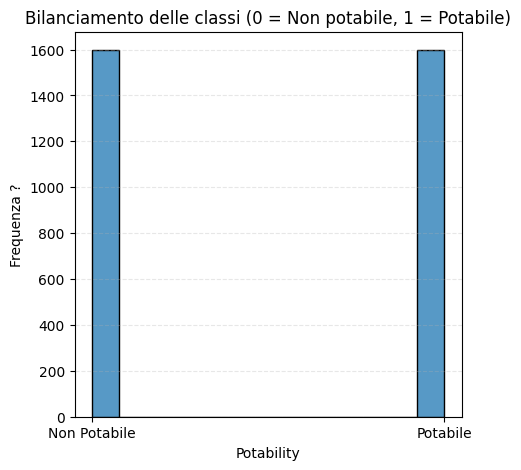

In [ ]:
plt.figure(figsize=(5, 5)) # Imposta le dimensioni del grafico
sns.histplot(x=y_train_balanced)
plt.title('Bilanciamento delle classi (0 = Non potabile, 1 = Potabile)')
plt.ylabel('Frequenza ?') # Etichetta asse Y
plt.xticks(ticks=[0, 1], labels=['Non Potabile', 'Potabile'])
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

#-----------------------------------------------
# # 2. Preparazione per il Modeling
#-----------------------------------------------

#Standardizzazione valori (se necessario)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_imputed)

#-----------------------------------------------
# # 3. Modeling e Valutazione
#-----------------------------------------------

# Scelta modelli (StratifiedKFold per trovare il modello piu' adatto al dataset)

Ora che abbimao completato tutti i controlli e aggiustamenti possiamo iniziare la nostra creazione del modello.
Inizieremo con un modello base come baseline dei modelli che proveremo successivamente.

In [ ]:
# modello base
#Valutazione modello base

base_model = LogisticRegression()
base_model.fit(X_train_scaled, y_train_balanced)

LogisticRegression()

Non sappiamo quale modello è il piu' adatto quindi grazie ad una tupla li proveremo tutti per trovare quello piu' performante.

In [ ]:
# trova modello migliore
models = [
    ('LR', LogisticRegression()),
    ('SVM', SVC(probability=True)),
    ('NB', GaussianNB()),
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('GB', GradientBoostingClassifier()),
    ('KNN', KNeighborsClassifier())
]

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models:
    cv_results = cross_val_score(model, X_train_scaled, y_train_balanced, cv=kfold, scoring='accuracy')
    results.append((name, cv_results.mean(), cv_results.std()))

# Ordina per performance

models_df = pd.DataFrame(results, columns=['Model', 'Mean Accuracy', 'Std Dev'])
models_df = models_df.sort_values(by='Mean Accuracy', ascending=False)

In [ ]:
# Visualizza il modelli
print("\nConfronto dei Modelli (Cross-Validation)")
print("-" * 40)
print(models_df)


Confronto dei Modelli (Cross-Validation)
----------------------------------------
  Model  Mean Accuracy   Std Dev
4    RF       0.705255  0.005540
1   SVM       0.671148  0.014289
6   KNN       0.642680  0.006209
5    GB       0.615760  0.020562
3    DT       0.610764  0.014714
2    NB       0.564450  0.013019
0    LR       0.497186  0.015055


In [ ]:
# Get the best model from the cross-validation
best_model_name = models_df.iloc[0]['Model']
print(f"Il miglior modello basato sulla cross-validation è: {best_model_name}")
# Get the best model class from the dictionary
best_model_class = None
for name, model_instance in models:
    if name == best_model_name:
        # Get the class from the instance
        best_model_class = type(model_instance)
        break

# Now, instantiate the best model class
model_to_optimize = best_model_class(random_state=42)

Il miglior modello basato sulla cross-validation è: RF


Abbiamo la conferma che la RandomForest è il modello corretto per la continuazione del modello finale, ora ci serve trovare gli iperparametri migliori e avere il setup perfetto.
Useremo solo alcuni iperparametri ma comunque tra i piu' importanti per non complicare troppo ed alleggerire il lavoro.
(cv=3 perché ci mette già tanto tempo a eseguire su colab, all'inizio avevo provato 5 per maggiore precisione ma ci metteva piu' di 20minuti)

# Ottimizzazione iperparametri (GridSearchCV lento ma op, RandomizedSearchCV veloce ma less accurate)

In [ ]:
# lista parametri solitamente ottimale perche prova tante cose
# Definizione dei parametri da ottimizzare
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [ ]:
print("\n--- Ricerca dei migliori iperparametri ---")

# Usa la cross-validation (cv=5) per una stima robusta
grid_search = GridSearchCV(
    estimator=model_to_optimize,
    param_grid=param_dist,
    cv=3,
    scoring='accuracy', # o 'f1' se il dataset è sbilanciato
    n_jobs=-1, # Usa tutti i core disponibili per velocizzare
)

# Esecuzione della ricerca
# Il fit trova la combinazione migliore usando X_train_scaled e y_train
grid_search.fit(X_train_scaled, y_train_balanced)


--- Ricerca dei migliori iperparametri ---


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='accuracy')

In [ ]:
# Visualizzazione dei risultati
print("Migliori iperparametri trovati:")
print(grid_search.best_params_)

Migliori iperparametri trovati:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
print(f"\nMigliore accuratezza media con cross-validation: {grid_search.best_score_:.4f}")

# Ottenimento del modello ottimizzato
best_model = grid_search.best_estimator_


Migliore accuratezza media con cross-validation: 0.6912


# Valutazione finale (usare testset per controllare il comportamento dei modelli, uso di confusion matrix, report di classificazione, curca roc-auc

In [ ]:
# 1. Valutazione del Modello Base
print("--- Valutazione del Modello Base ---")
y_pred_base = base_model.predict(X_test_scaled)
y_pred_proba_base = base_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Calcolo delle metriche
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, y_pred_proba_base)
conf_matrix_base = confusion_matrix(y_test, y_pred_base)

In [ ]:
# Stampa i risultati
print(f"Accuratezza: {accuracy_base:.4f}")
print(f"Precisione: {precision_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print(f"F1-Score: {f1_base:.4f}")
print(f"AUC: {auc_base:.4f}")
print("\nReport di Classificazione:")
print(classification_report(y_test, y_pred_base))

In [ ]:
# Visualizza la matrice di confusione
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base).plot(ax=ax)
plt.title('Matrice di Confusione - Modello Base')
plt.show()

In [ ]:
# 2. Valutazione del Modello Ottimizzato
print("\n--- Valutazione del Modello Ottimizzato ---")
y_pred_optimized = best_model.predict(X_test_scaled)
y_pred_proba_optimized = best_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Calcolo delle metriche
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

In [ ]:
# Stampa i risultati
print(f"Accuratezza: {accuracy_optimized:.4f}")
print(f"Precisione: {precision_optimized:.4f}")
print(f"Recall: {recall_optimized:.4f}")
print(f"F1-Score: {f1_optimized:.4f}")
print(f"AUC: {auc_optimized:.4f}")
print("\nReport di Classificazione:")
print(classification_report(y_test, y_pred_optimized))

In [ ]:
# Visualizza la matrice di confusione
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_optimized).plot(ax=ax)
plt.title('Matrice di Confusione - Modello Ottimizzato')
plt.show()

In [ ]:
# 3. Confronto Visivo (Curva ROC)
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_base)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Modello Base (AUC = {auc_base:.2f})')
plt.plot(fpr_optimized, tpr_optimized, label=f'Modello Ottimizzato (AUC = {auc_optimized:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Casuale')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Conclusione
Dopo il confronto notiamo subito un notevole miglioramento dal modello base a quello ottimizzato.
I risultati sono ancora 'troppo' bassi per quello che vorremmo da un modello che predice se l'acqua è potabile o meno.
Però le cross validation avevano anche valori inferiori dato il peso del dataset in se.

# XGBoost
Ho provato a cambiare approccio diverso per vedere se cambiava qualcosa con xgboost, purtroppo anche con questo già solo stampando i dati i risultati non sono granché migliori.

In [ ]:
# Inizializza il classificatore XGBoost
# Usa l'oggeto DMatrix per ottimizzare le prestazioni di XGBoost
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 4, 5],            # Profondità massima degli alberi
    'subsample': [0.7, 0.8, 0.9],      # Frazione di campioni per ogni albero
    'colsample_bytree': [0.7, 0.8, 0.9] # Frazione di feature per ogni albero
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1', # O 'roc_auc' se preferisci, molto usata per la classificazione
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("Inizio la ricerca degli iperparametri...")
grid_search.fit(X_train, y_train)

Inizio la ricerca degli iperparametri...
Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:11:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='f1', verbose=1)

In [ ]:
# --- 3. Valutazione del Modello Ottimizzato ---
# Stampa i migliori parametri trovati.
print("\n--- Risultati dell'ottimizzazione ---")
print("Migliori iperparametri trovati:", grid_search.best_params_)

# Ottengo il modello migliore dalla ricerca.
best_model = grid_search.best_estimator_

# Faccio previsioni sul set di test con il modello ottimizzato.
y_pred_tuned = best_model.predict(X_test)

# Stampo un report completo per valutare il modello.
print("\n--- Report di Classificazione del Modello Ottimizzato ---")
print(classification_report(y_test, y_pred_tuned))


--- Risultati dell'ottimizzazione ---
Migliori iperparametri trovati: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}

--- Report di Classificazione del Modello Ottimizzato ---
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       400
           1       0.47      0.36      0.41       256

    accuracy                           0.59       656
   macro avg       0.56      0.55      0.55       656
weighted avg       0.58      0.59      0.58       656



Se dovesse essere necessario, stavo pensando si potesse modificare alcune feature come il ph e farle diventare categoriche, in modo da avere piu chiari dei dati, anche perché probabilmente se un acqua acida o basica probabilmente non è potabile, quindi come infomazione potrebbe aiutare. Ovviamente non lo so è solo un pensiero se il progetto non dovesse essere abbastanza, non so se ci sono altre feature che farebbero al caso nostro come il ph ma in caso controllerei. Al di fuori di questo o ci sono errori da parte mia o magari il dataset non è adatto all'apprendimento automatico ma piu' ad un modello con regole chiare, dove se un "acqua" non rispetta certi valori in ogni feature allora viene categorizzata come non potabile. Questo è tutto e un piccolo pensiero mio a fine lavoro, grazie.